In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gzip
import pickle
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import table, coordinates, units as u
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import interpolate
import ephem # to make coordinate systems conversions
#python3 serialize_ztf_model.py PALEO_ZTF_MODEL90_SNIa-SALT2_for_Daniel

In [2]:
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Read the data

The functions bellow will convert the pkl file into pandas data frames

In [3]:
LSST_FILTERS = 'ugrizY'


def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIax', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            
            #make mag
            sn['mag_%s' % filt] = np.array(-2.5*np.log10(np.abs(sn[filt]['fluxcal'])))+27.5
            
            sn['snr_%s' % filt] = (sn[filt]['fluxcalerr'] / np.abs(sn[filt]['fluxcal']))

        
            sn['magerr_%s' % filt] = np.array(1.086 * sn['snr_%s' % filt])
            sn['magerr_%s' % filt][sn['magerr_%s' % filt] > 0.5] = 0.5
            #  find candence
            
            sn['delta_t_%s' % filt] = [j-i for i, j in zip(sn['mjd_%s' % filt][:-1], sn['mjd_%s' % filt][1:])]
            sn['median_delta_t_%s' % filt] = np.array(np.median(sn['delta_t_%s' % filt]))
            
            sn['magobs_%s' % filt] = np.array(np.median(sn['delta_t_%s' % filt]))
            
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

In [4]:
models = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/rates.csv", header=None, names=['RESULT', 'Num', 'Model', 'NGEN', 'NGEN_WRITE', 'Err', 'Frac'])
mod_names = ["_".join(x.split("_")[5:]) for x in models['Model']]
NLC = models['NGEN_WRITE']
NLC_scaled = [int(x*0.02) for x in NLC]
DF_scaled = pd.DataFrame({'Names':mod_names, 'NLC':NLC})

In [5]:
simDir = "/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/"
prefix = "MLAG_GP_ELASTICC_TEST_LSST_WFD_"

AGN, y = read_data(simDir + "/" + prefix + 'AGN.pkl.gz') 
KN_K, y = read_data(simDir + "/" + prefix + 'KN_K17.pkl.gz')  
KN_B, y = read_data(simDir + "/" + prefix + 'KN_B19.pkl.gz') 
SLSN, y = read_data(simDir + "/" + prefix + 'SLSN-I.pkl.gz') 
CC1, y = read_data(simDir + "/" + prefix + 'SNII+HostXT_V19.pkl.gz')  
CC2, y = read_data(simDir + "/" + prefix + 'SNII-NMF.pkl.gz')  
CC3, y = read_data(simDir + "/" + prefix + 'SNII-Templates.pkl.gz') 
SNIIb, y = read_data(simDir + "/" + prefix + 'SNIIb+HostXT_V19.pkl.gz')
SNIIn1, y = read_data(simDir + "/" + prefix + 'SNIIn+HostXT_V19.pkl.gz')
SNIIn2, y = read_data(simDir + "/" + prefix + 'SNIIn-MOSFIT.pkl.gz')
TDE, y = read_data(simDir + "/" + prefix + 'TDE.pkl.gz')  
SNIax, y = read_data(simDir + "/" + prefix + 'SNIax.pkl.gz')  
SNIa91bg, y = read_data(simDir + "/" + prefix + 'SNIa-91bg.pkl.gz') 
SNIb1, y = read_data(simDir + "/" + prefix + 'SNIb+HostXT_V19.pkl.gz')  
SNIb2, y = read_data(simDir + "/" + prefix + 'SNIb-Templates.pkl.gz') 
SNIc1, y = read_data(simDir + "/" + prefix + 'SNIc+HostXT_V19.pkl.gz') 
SNIc2, y = read_data(simDir + "/" + prefix + 'SNIc-Templates.pkl.gz') 
SNIcBL, y = read_data(simDir + "/" + prefix + 'SNIcBL+HostXT_V19.pkl.gz')  
SNIa, y = read_data(simDir + "/" + prefix + 'SNIa-SALT2.pkl.gz') 

KN = pd.concat([KN_K, KN_B], ignore_index=True)
SNIb = pd.concat([SNIb1, SNIb2], ignore_index=True)
SNIc = pd.concat([SNIc1, SNIc2], ignore_index=True)
CC = pd.concat([CC1, CC2, CC3], ignore_index=True)
SNIIn = pd.concat([SNIIn1, SNIIn2], ignore_index=True)

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [6]:
SNIc2, y = read_data(simDir + "/" + prefix + 'SNIc-Templates.pkl.gz') 
SNIcBL, y = read_data(simDir + "/" + prefix + 'SNIcBL+HostXT_V19.pkl.gz')  
SNIa, y = read_data(simDir + "/" + prefix + 'SNIa-SALT2.pkl.gz') 

KN = pd.concat([KN_K, KN_B], ignore_index=True)
SNIb = pd.concat([SNIb1, SNIb2], ignore_index=True)
SNIc = pd.concat([SNIc1, SNIc2], ignore_index=True)
CC = pd.concat([CC1, CC2, CC3], ignore_index=True)
SNIIn = pd.concat([SNIIn1, SNIIn2], ignore_index=True)

In [164]:
leftoverOBJs = pd.concat([SNIa91bg['SIM_HOSTLIB_GALID'], SNIax['SIM_HOSTLIB_GALID']])
leftoverOBJs.to_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/leftoverOBJs.csv",index=False)

In [44]:
modelTypes = [AGN, KN, SLSN, CC, SNIIb, SNIIn, TDE, SNIax, SNIa91bg, SNIb, SNIc, SNIcBL, SNIa]

In [7]:
mags = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/LSSTmags.csv")
mags2 = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/LSSTmags_91bg.csv")
mags['SIM_HOSTLIB_GALID'] = mags['galaxy_id']
mags2['SIM_HOSTLIB_GALID'] = mags2['galaxy_id']

del mags['galaxy_id']
del mags2['galaxy_id']

mags = pd.concat([mags, mags2], ignore_index=True)

In [8]:
classes = [AGN, TDE, CC, SNIax, SNIIb, KN, SNIa91bg, SNIb, SNIc, SNIcBL, SNIa, SLSN, SNIIn] # SNIc, SNIcBL,  SNIax, SNIb,SNIa91bg,
names = ['AGN', 'TDE','SN II', 'SN Iax', 'SN IIb', 'Kilonova', 'SN 91bg-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'SN Ia',  'SLSN-I', 'SN IIn']
newNames = []
newClasses = []
for i in np.arange(len(classes)):
    SNclass = classes[i]
    name = names[i]
    SNclassNew = SNclass.merge(mags, on='SIM_HOSTLIB_GALID')
    SNclassNew.drop_duplicates(subset=['SIM_HOSTLIB_GALID'], inplace=True)
    if len(SNclassNew)> 0:
        newNames.append(name)
        newClasses.append(SNclassNew)
names = newNames.copy()
classes = newClasses.copy()

In [9]:
len(classes[6])

8057

In [114]:
test = []
for SNclass in classes:
    test.append(SNclass['SIM_HOSTLIB_GALID'].values)

In [117]:
test_final = np.concatenate(test)
df = pd.DataFrame({'galaxy_id':test_final})
df.drop_duplicates(inplace=True)
df.to_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/objids.csv",index=False)
len(df.drop_duplicates())

118192

In [ ]:
mags = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/SNANASims/10k_Sims/absoluteMags_10kSample.csv")

for SNclass in classes:
    SNclass

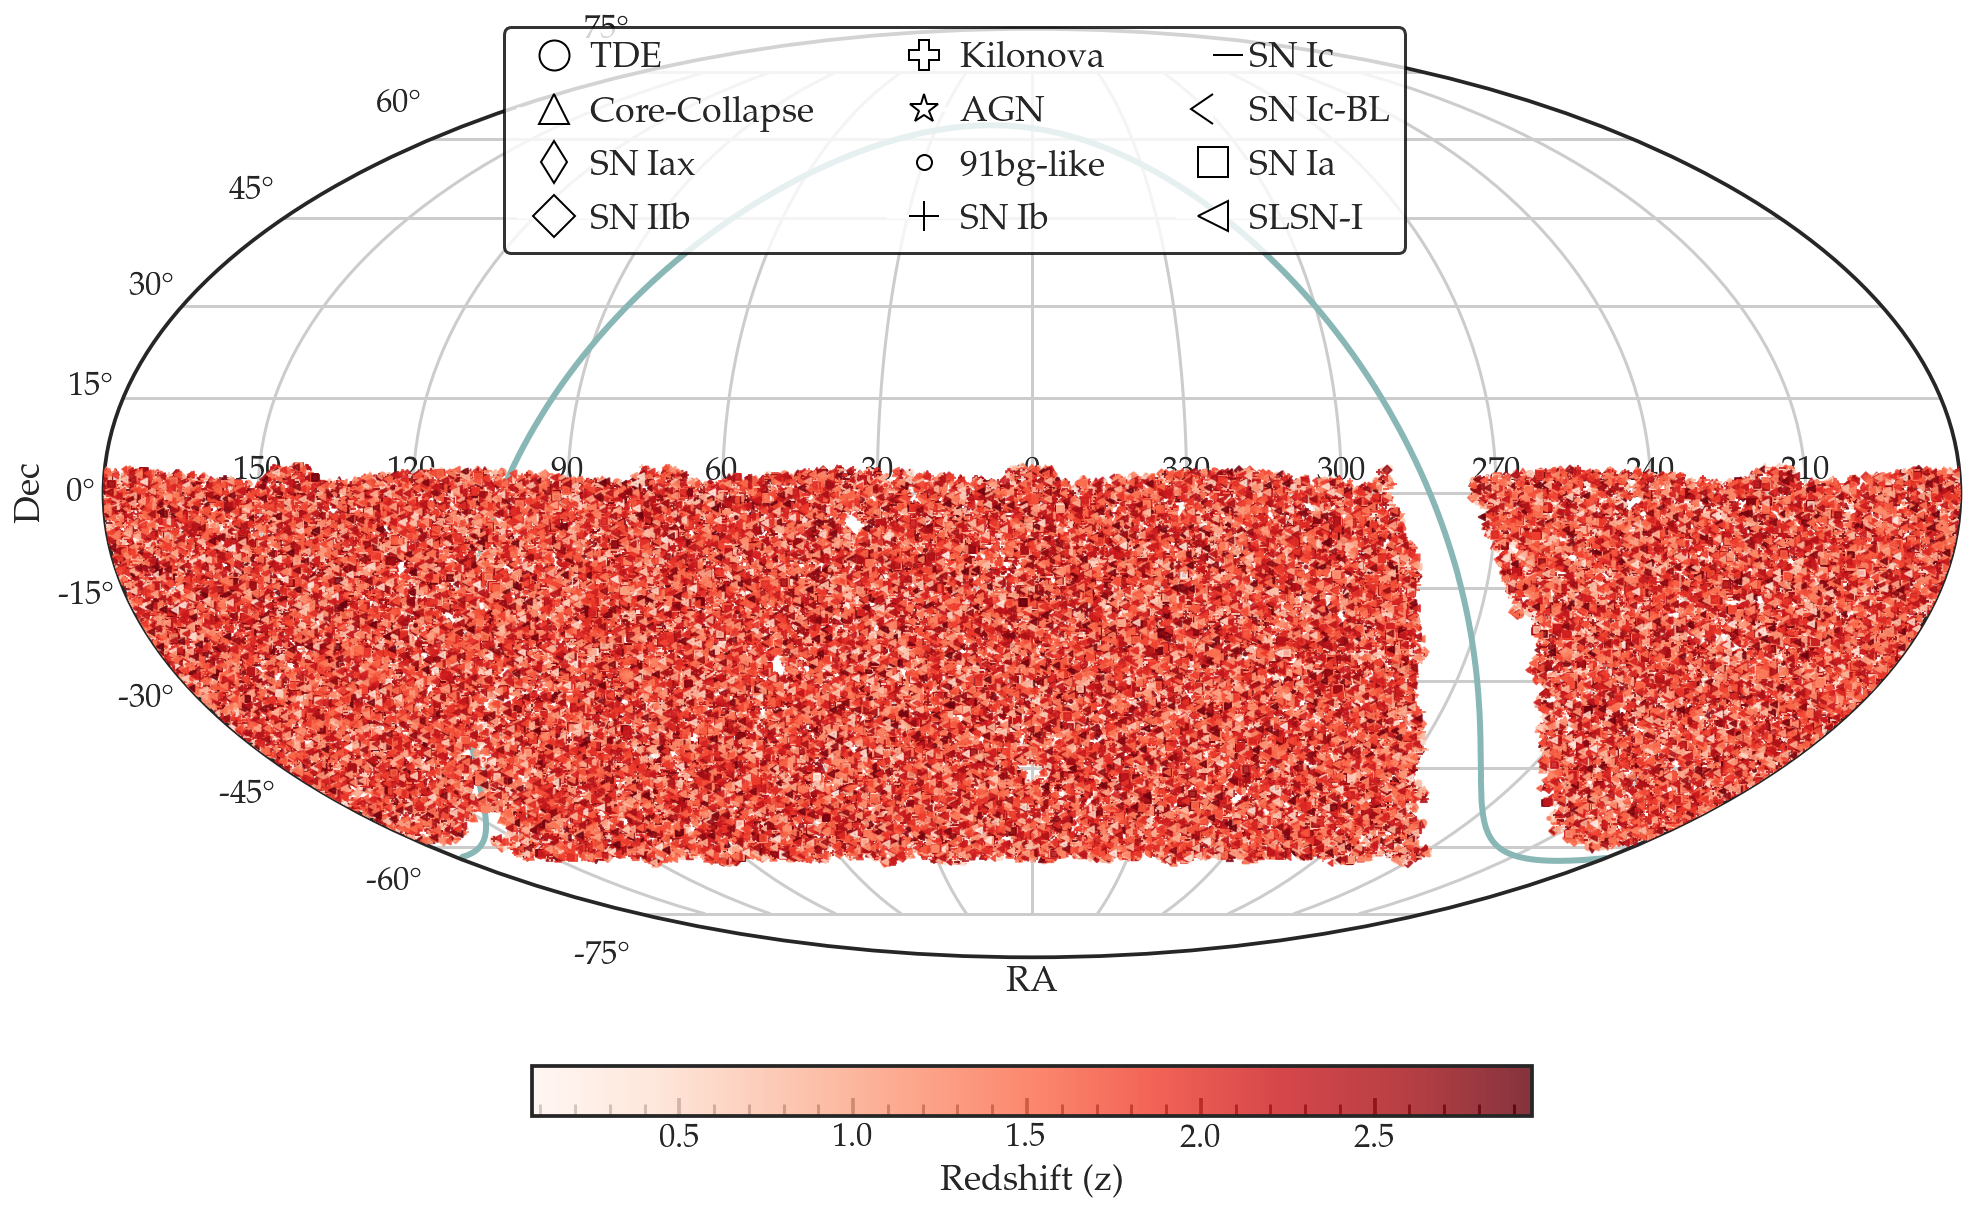

In [6]:
sns.set_context("talk")

org = 0

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='mollweide')
ax.set_xticklabels(tick_labels)
ax.title.set_fontsize(15)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.grid(True)
symb = ['o', '^','d','D','P', '*', '.', '+', 1, 8, 's', '<']

for i in np.arange(len(classes)):
    tclass = classes[i]
    RA = tclass['SIM_RA'].values
    Dec = tclass['SIM_DEC'].values
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    color = tclass['SIM_REDSHIFT_HELIO'].values
    c = ax.scatter(np.radians(x),np.radians(Dec), c=color, zorder=300, cmap='Reds', s=10, lw=1, marker=symb[i], label=names[i], alpha=0.8)  # convert degrees to radians

legend_elements = []
for i in np.arange(len(classes)):
    legend_elements.append(Line2D([0], [0], marker=symb[i], color='w', label=names[i],
                        markerfacecolor='w', mec='k',markersize=15, mew=1))
    
leg1 = ax.legend(fontsize=18, handles=legend_elements, loc='lower right', handletextpad=0.0, borderaxespad=1.5,labelspacing=0.5, bbox_to_anchor=(0.73,0.7), ncol=3,frameon=True, fancybox=True, edgecolor='k')
    
x = plt.colorbar(c,fraction=0.046, pad=0.1, label=r'Redshift (z)', orientation="horizontal")

lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = eq_array[:,0]
Dec = eq_array[:,1]

x = np.remainder(RA+360-org,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x    # reverse the scale: East to the left
Gal_Equator = pd.DataFrame({'x':np.radians(x), 'y':np.radians(Dec)})
Gal_Equator.sort_values(by='x', inplace=True)
ax.plot(Gal_Equator['x'], Gal_Equator['y'], lw=3, c='#88B7B5')
plt.savefig("../plots/GP_Simulated_allSamples_LSST_Redshifts.png",dpi=300, bbox_inches='tight')

In [185]:
#KN: 595+513

1108

In [ ]:
#SNIa 

In [202]:
DF_scaled['SuperScaled'] = DF_scaled['NLC']*0.0005

In [203]:
DF_scaled

Names       NLC  SuperScaled
0              KN_K17       595       0.2975
1              KN_B19       513       0.2565
2              SLSN-I     76686      38.3430
3                 TDE     54652      27.3260
4                 AGN    174833      87.4165
5        SNIIn-MOSFIT    954415     477.2075
6    SNIIn+HostXT_V19   1723259     861.6295
7            SNII-NMF  10853050    5426.5250
8      SNII-Templates   9610788    4805.3940
9     SNII+HostXT_V19  21341766   10670.8830
10     SNIb-Templates   2800794    1400.3970
11    SNIb+HostXT_V19   3496230    1748.1150
12     SNIc-Templates   1337387     668.6935
13    SNIc+HostXT_V19   2431280    1215.6400
14  SNIcBL+HostXT_V19    670240     335.1200
15   SNIIb+HostXT_V19   6538537    3269.2685
16         SNIa-SALT2  16193038    8096.5190
17          SNIa-91bg   1079102     539.5510
18              SNIax   3764597    1882.2985

In [ ]:
SNIa: 8097
SNIc: 669
SNIax: 1882 
SNIIb: 3269
AGN: 87
TDE: 27

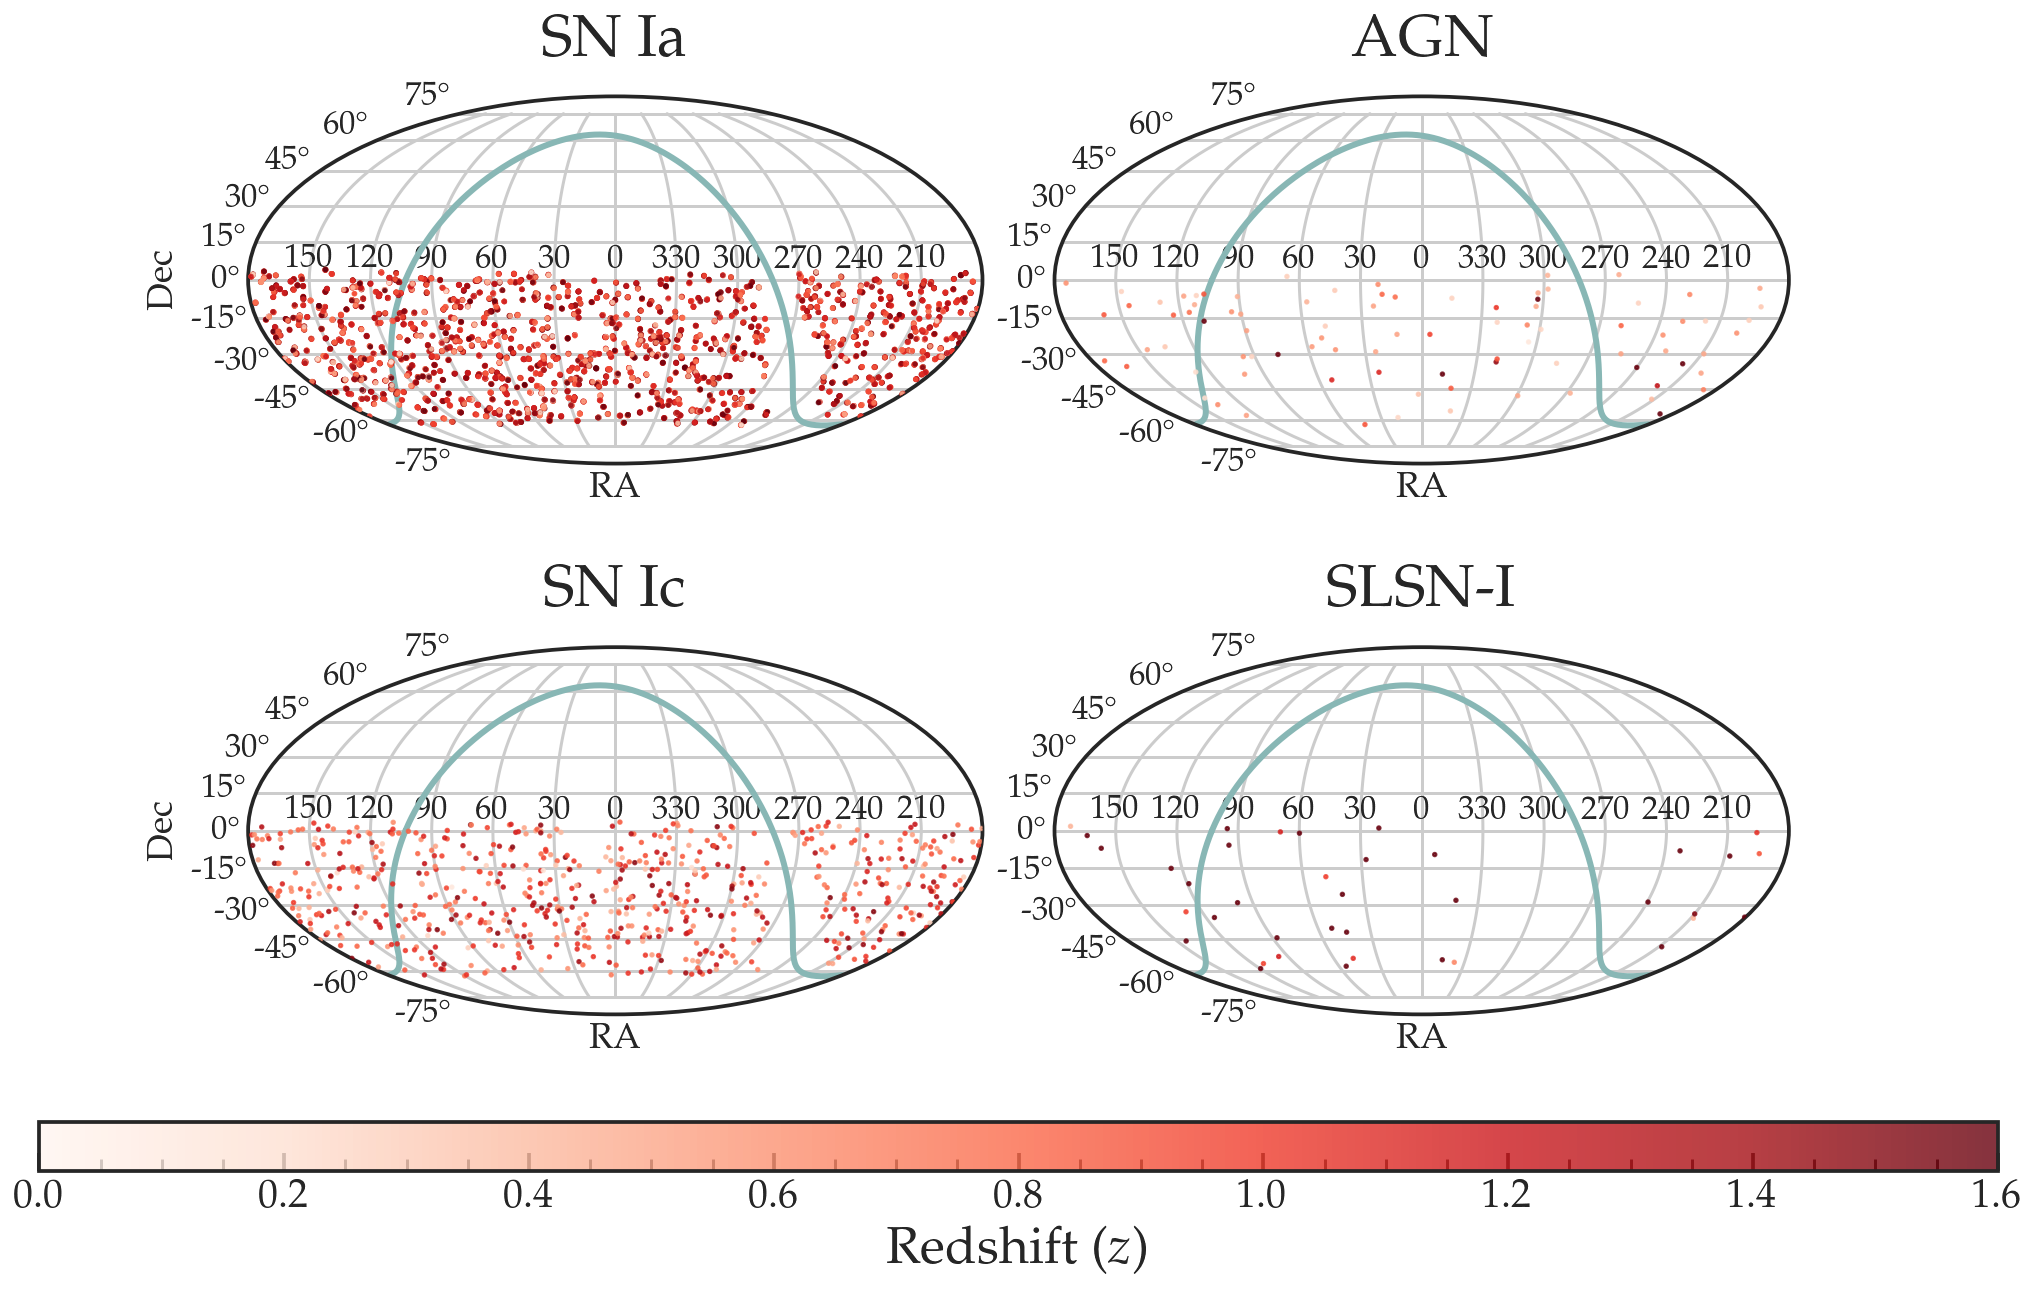

In [207]:
#classes = [CC1, KN, SLSN, SNIa]  
classes = [SNIc.sample(669), SNIa.sample(8097), SLSN.sample(38), AGN.sample(87)]
names = ['SN Ic', 'SN Ia', 'SLSN-I', 'AGN']
#names = ['SN II', 'Kilonova', 'SLSN-I', 'SN Ia']

DF_scaled

sns.set_context("talk")
cols = sns.color_palette("muted", 12)#['#437C90', '#255957', '#EEEBD3', '#A98743','#F7C548','#9C3848','#590925','#CC2936','#2E1760','#D65780', '#9A94BC', '#A5C882']
org = 0

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(80, 30))
temp = []
for j in np.arange(2):
    for k in np.arange(2):
        ax = fig.add_subplot(6,j+1,k+1, projection='mollweide')
        temp.append(ax)
        ax.set_xticklabels(tick_labels)
        ax.title.set_fontsize(15)
        ax.set_xlabel("RA")
        if j==0:
            ax.set_ylabel("Dec")
        ax.grid(True)
        symb = ['o', '^','d','D','P', '*', '.', '+', 1, 8, 's', '<']
        ax.set_position(pos=[0.1+0.07*j, 0.1+0.15*k,0.1,0.1])
        ax.set_title(names[k +2*j],fontsize=30, pad=20)

        tclass = classes[k+2*j]
        RA = tclass['SIM_RA'].values
        Dec = tclass['SIM_DEC'].values
        x = np.remainder(RA+360-org,360) # shift RA values
        ind = x>180
        x[ind] -=360    # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        color = tclass['SIM_REDSHIFT_HELIO'].values
        c = ax.scatter(np.radians(x),np.radians(Dec), c=color, zorder=300, cmap='Reds', s=3, lw=1, marker='o', label=names[j], alpha=0.8, vmin=0., vmax=1.6)  # convert degrees to radians

        legend_elements = []
        
        lon_array = np.arange(0,360)
        lat = 0.
        eq_array = np.zeros((360,2))
        for lon in lon_array:
            ga = ephem.Galactic(np.radians(lon), np.radians(lat))
            eq = ephem.Equatorial(ga)
            eq_array[lon] = np.degrees(eq.get())
        RA = eq_array[:,0]
        Dec = eq_array[:,1]

        x = np.remainder(RA+360-org,360) # shift RA values
        ind = x>180
        x[ind] -=360    # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        Gal_Equator = pd.DataFrame({'x':np.radians(x), 'y':np.radians(Dec)})
        Gal_Equator.sort_values(by='x', inplace=True)
        ax.plot(Gal_Equator['x'], Gal_Equator['y'], lw=3, c='#88B7B5')
x = fig.colorbar(c,fraction=0.05, pad=0.1,label=r'Redshift (z)', ax=temp, orientation="horizontal", aspect=40)
x.set_label(label=r'Redshift ($z$)', size='x-large')
x.ax.tick_params(labelsize=20) 
#plt.savefig("../plots/GP_Simulated_allSamples_LSST_Redshifts_MultiClass.png",dpi=300, bbox_inches='tight')

# Now you can use the data doing

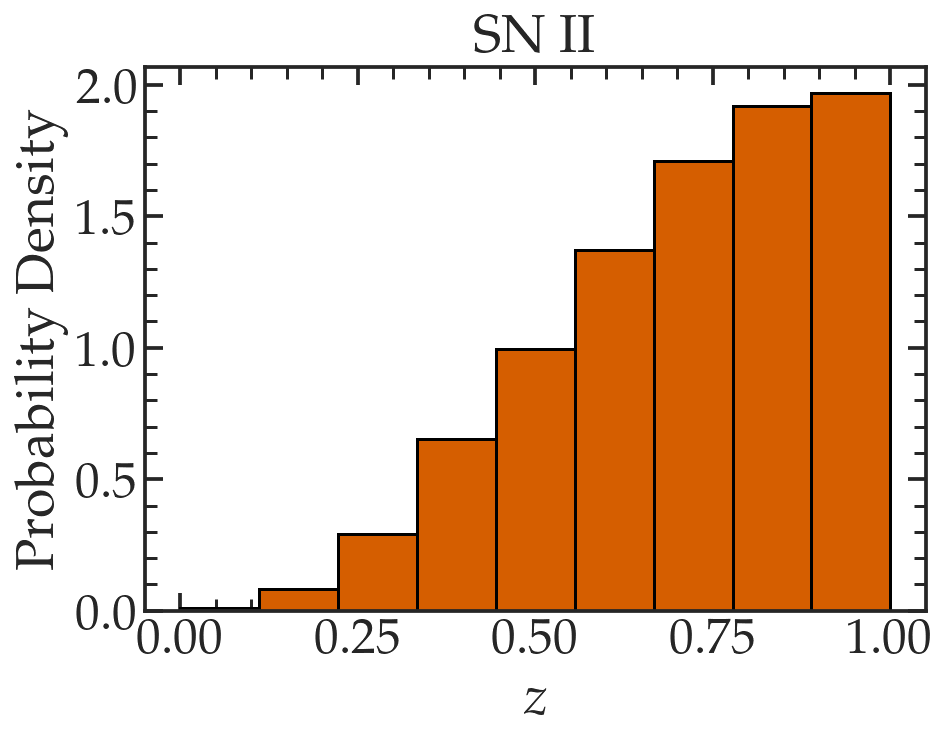

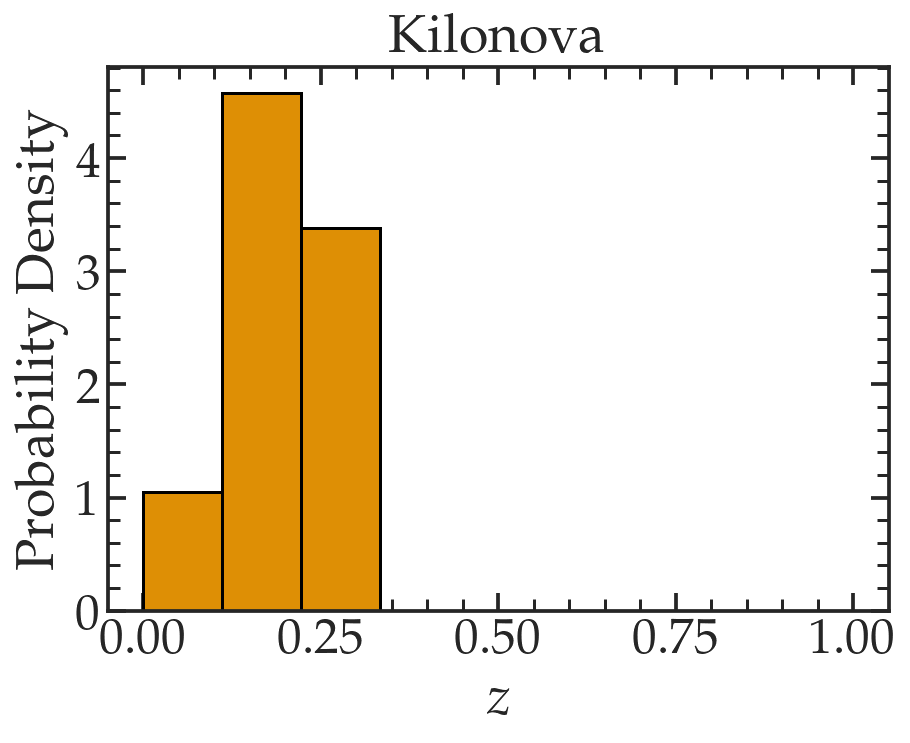

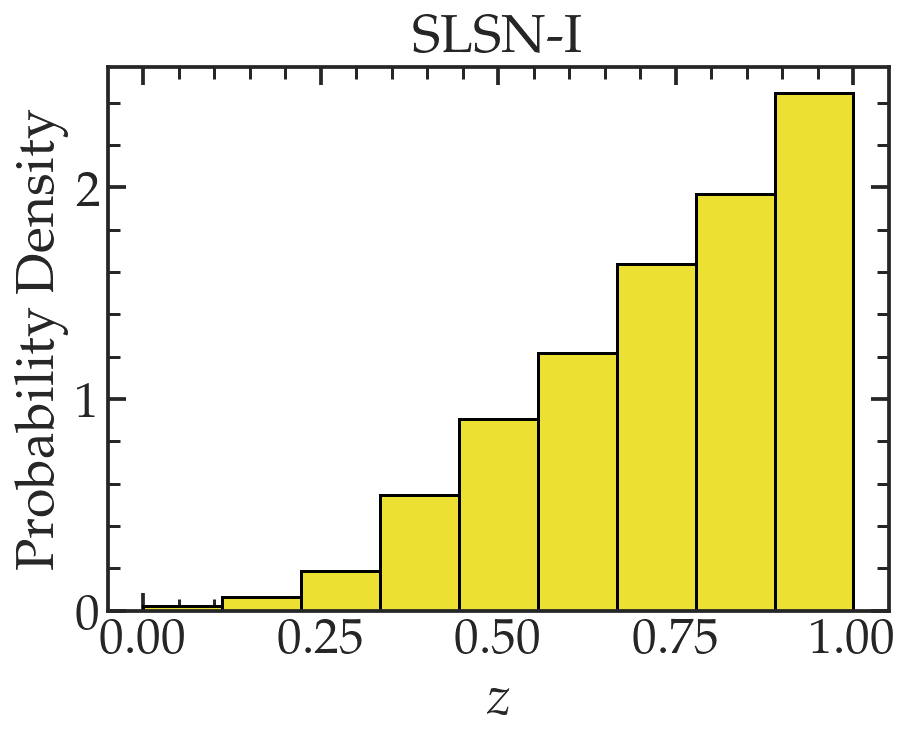

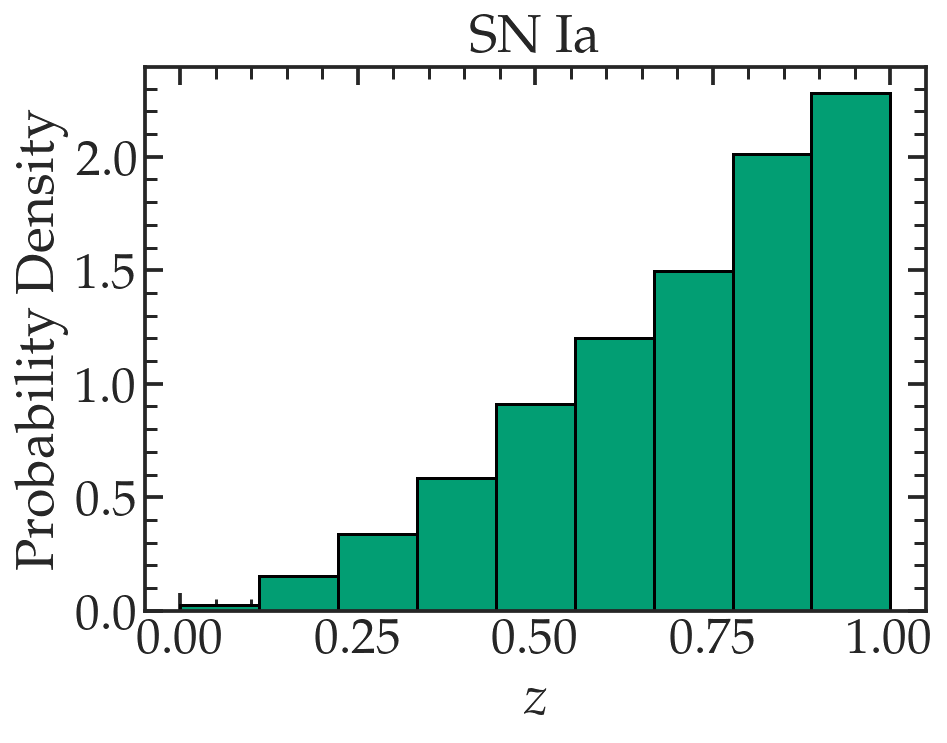

In [30]:
sns.set_context("talk",font_scale=1.5)

cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])

for i in np.arange(len(classes)):
    plt.figure(figsize=(7,5))
    plt.hist(classes[i]['z'], density=True, color=cols[i], edgecolor='k', bins=np.linspace(0, 1, 10))
    plt.title(names[i])
    plt.xlabel(r"$z$")
    plt.ylabel(r"Probability Density")
    #plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_Redshift_%s.png"%(names[i]),bbox_inches='tight',dpi=200)

The `X` contain the data itself. You can take a look at what IDs are present in X by using

Text(0, 0.5, '$g$')

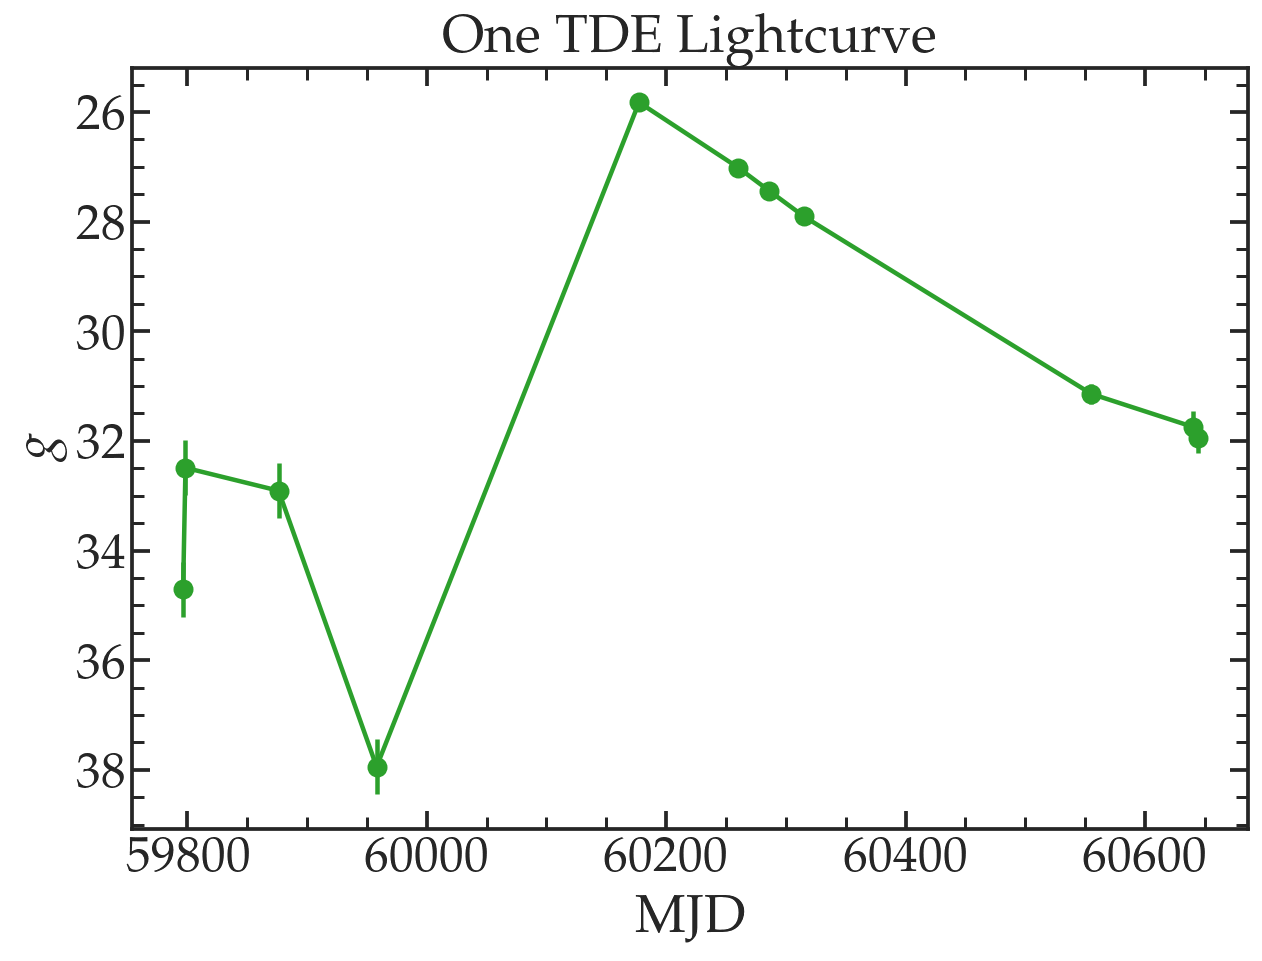

In [35]:
plt.figure(figsize=(10,7))
plt.errorbar(TDE.loc[TDE.index[0], 'mjd_g'], TDE.loc[TDE.index[0], 'mag_g'], yerr=TDE.loc[TDE.index[0], 'magerr_g'], fmt='o-', c='tab:green')
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.title("One TDE Lightcurve")
plt.ylabel(r"$g$")

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


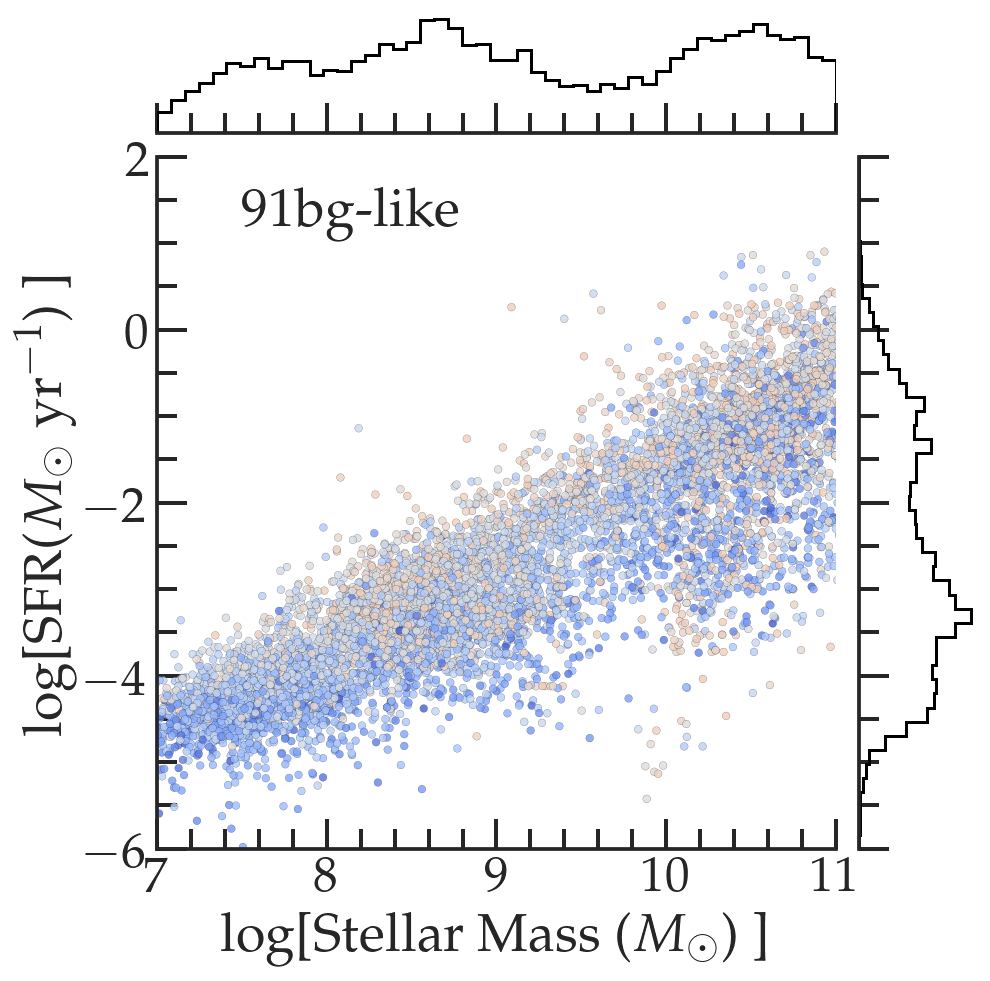

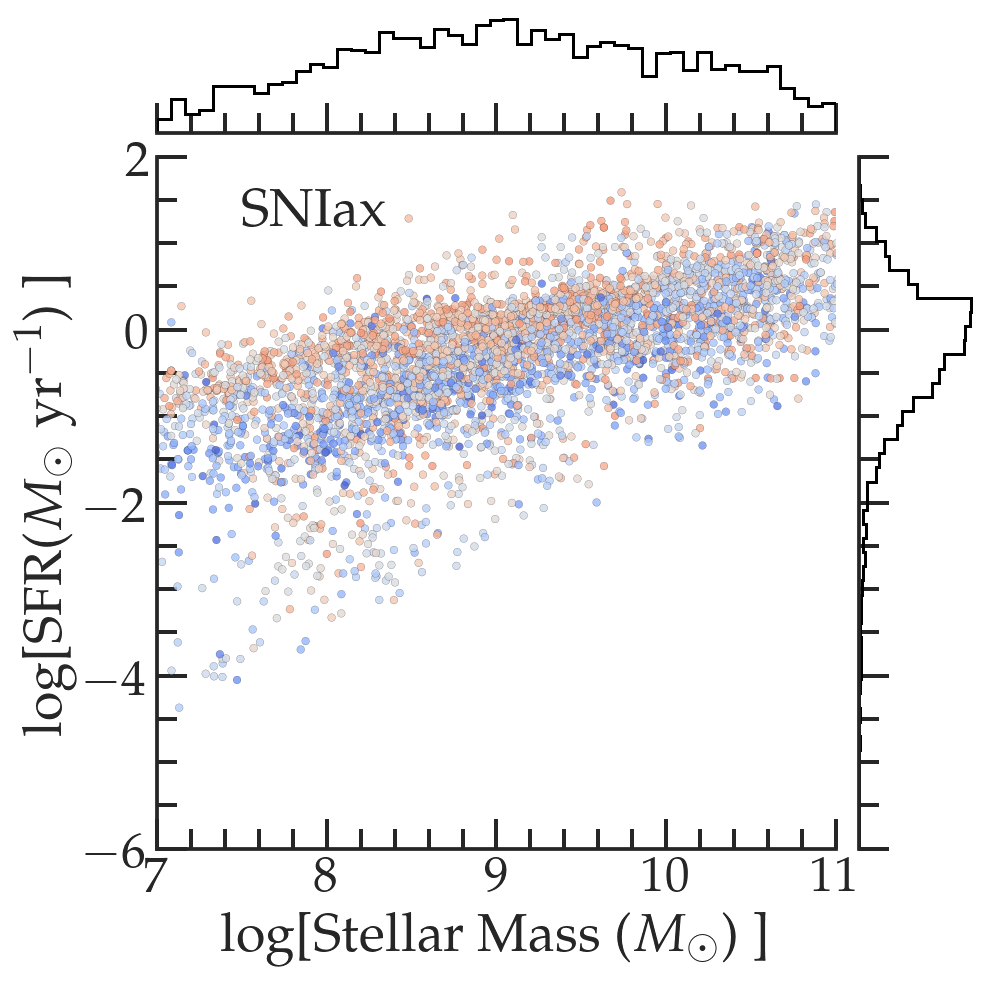

In [168]:
classes_plot = [SNIa91bg, SNIax]
names_plot = ['91bg-like', 'SNIax']

%matplotlib inline

sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

for i in np.arange(len(classes_plot)):
    #try:
    logmass = classes_plot[i]["SIM_HOSTLIB(LOGMASS_TRUE)"].values
    logsfr = classes_plot[i]["SIM_HOSTLIB(LOG_SFR)"].values
   # except:
   #     print("need to add in the mass and sfr info for index %i"%i)
   #     logmass = classes[i]["HOSTGAL_LOGMASS"].values
   #     logsfr = np.log10(classes[i]["HOSTGAL_sSFR"].values*10**classes[i]["HOSTGAL_LOGMASS"].values)   
   #     continue
    g = sns.JointGrid(x=logmass, y=logsfr,  xlim=(7, 11), ylim=(-6, 2), height=7)
    g = g.plot_joint(sns.scatterplot, hue=classes_plot[i]["SIM_REDSHIFT_HELIO"].values, palette='coolwarm', edgecolor="k", s=15, alpha=0.8,linewidth=0.1, hue_norm=(0, 2), legend=False)
    g.ax_joint.text(7.5, 1.2, "%s"%names_plot[i])
    
    g.ax_joint.set_ylabel("log[SFR($M_{\odot}\;\mathrm{yr}^{-1}$) ]")
    g.ax_joint.set_xlabel(r"log[Stellar Mass ($M_{\odot}$) ]")
    
    _ = g.ax_marg_x.hist(logmass,
                          bins=np.linspace(7., 11., 50), density=True, histtype ='step', fill=False, color='k')
    _ = g.ax_marg_y.hist(logsfr, 
                          orientation="horizontal",
                          bins=np.linspace(-6., 2., 50), density=True,histtype ='step',  Fill=False, color='k')
    
    if names[i] == 'Kilonova':
        g.ax_joint.errorbar(10.777, np.log10(0.08), fmt='d', uplims=[1], yerr=0.3, xerr=0.3,  c='#06A77D', ms=15, mec='k')
    plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_BubblePlot_%s.png"%names_plot[i].replace(" ", ""),bbox_inches='tight',dpi=200)

In [244]:
GHOST = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/GHOST_orig/GHOST_restFrame_condenseLabels_cleanColor.tar.gz")

In [175]:
from astropy.cosmology import WMAP7
z = np.linspace(0.01, 1.5, 60)
absCut= []
for onez in z:
    absCut.append(28 - WMAP7.distmod(onez).value)

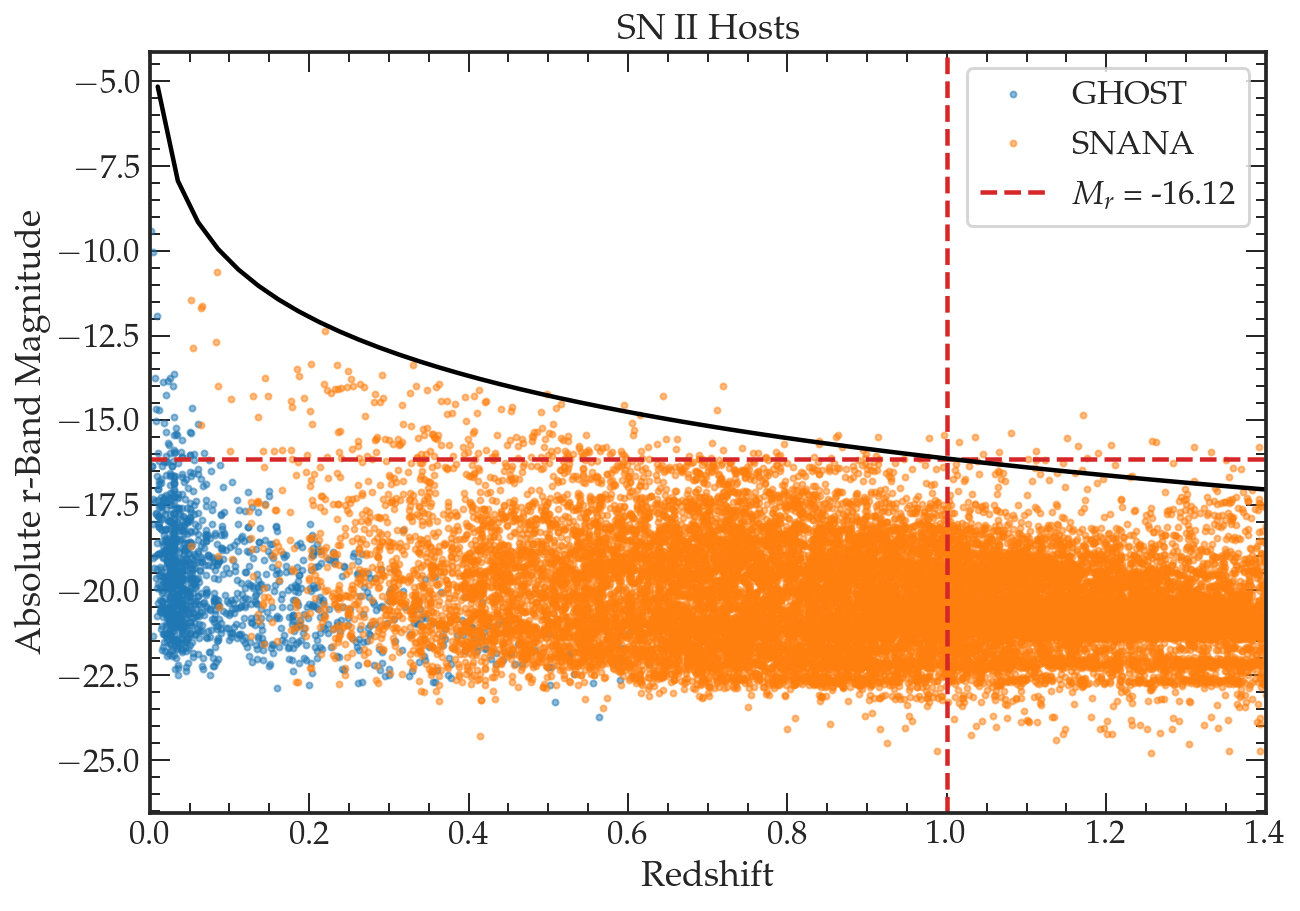

In [203]:
val = 28 - WMAP7.distmod(1).value

plt.figure(figsize=(10,7))
plt.plot(GHOST.loc[GHOST['TransientClass'] == 'SN II', 'TransientRedshift'],GHOST.loc[GHOST['TransientClass'] == 'SN II', 'rKronMag_SDSS_abs'], 'o',ms=3, label='GHOST', alpha=0.5)
plt.plot(classes[2]['SIM_REDSHIFT_HELIO'], classes[2]['Mag_true_r_sdss_z0'], 'o', ms=3, label='SNANA', alpha=0.5)
plt.axvline(x=1.0,  ls='--', c='tab:red')
plt.axhline(y=val, ls='--', c='tab:red', label=r'$M_r$ = %.2f'%val)
plt.plot(z, absCut, c='k')
plt.xlabel("Redshift")
plt.xlim((0, 1.4))
plt.ylabel("Absolute r-Band Magnitude")
plt.legend()
plt.title("SN II Hosts")
plt.savefig("/Users/alexgagliano/Documents/Research/DESC/transient-host-sims/plots/SNII_truncatedSample.png",dpi=200, bbox_inches='tight')

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


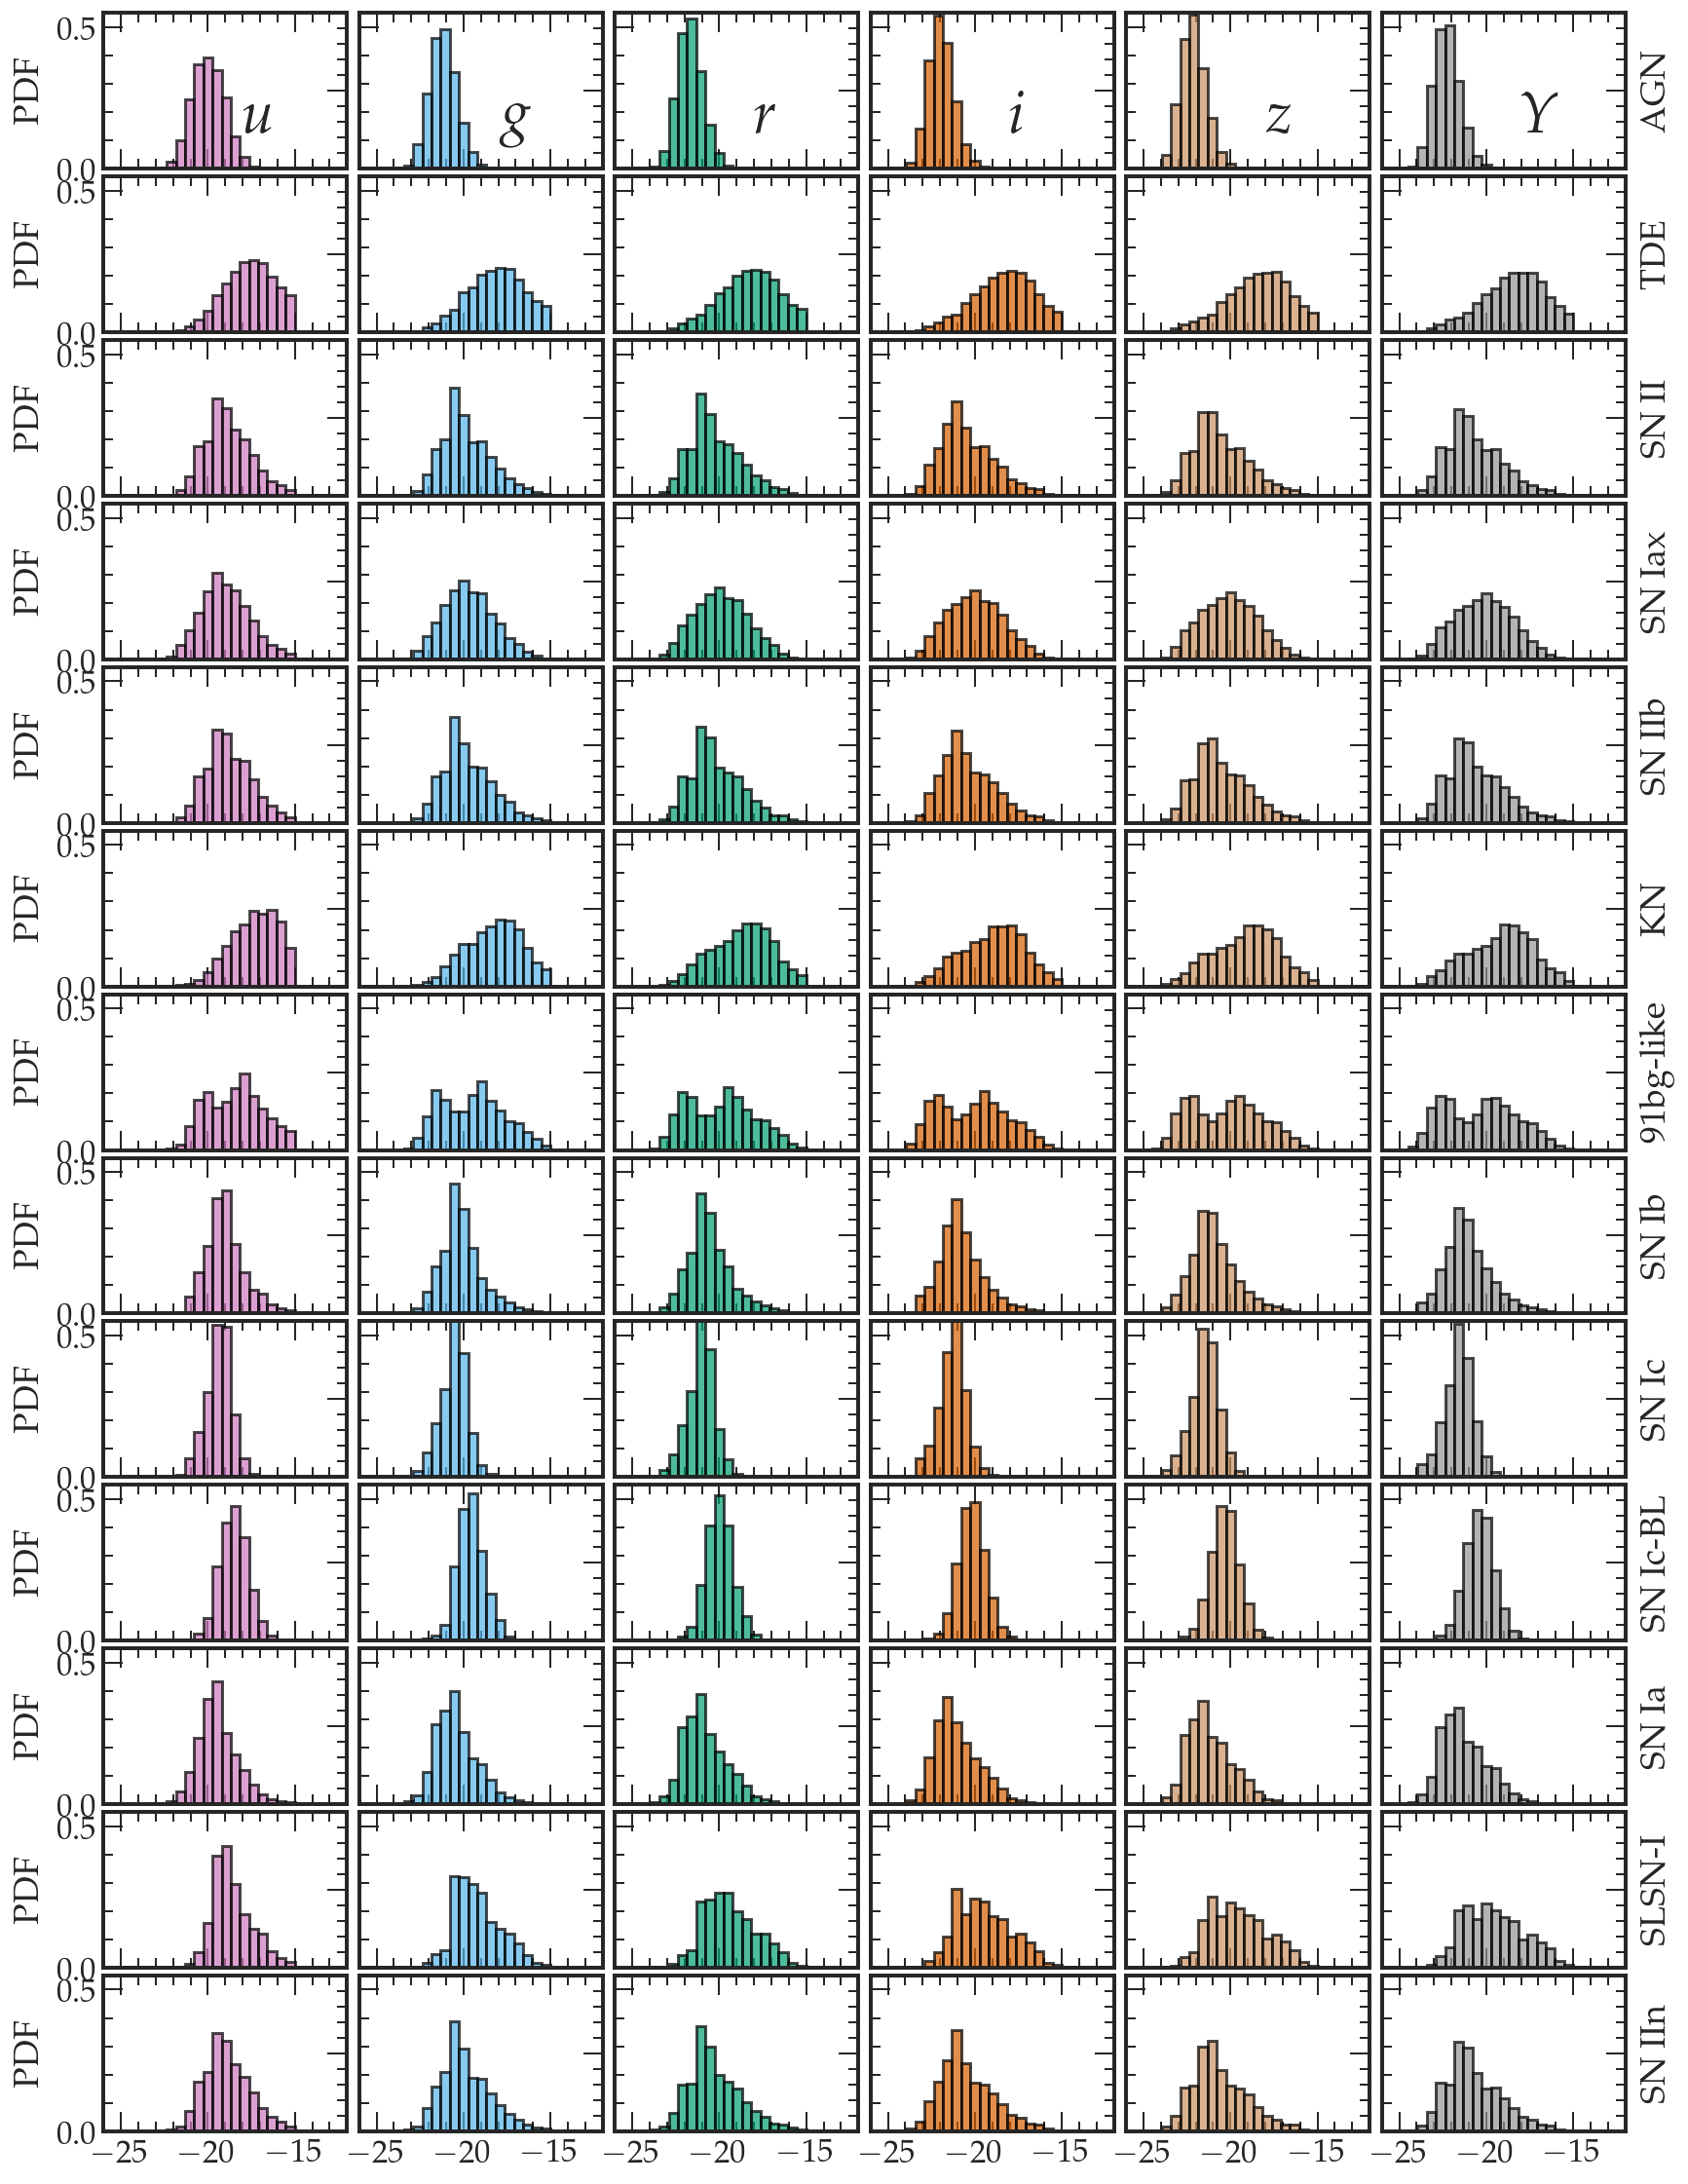

In [169]:
sns.set_context("talk",font_scale=1.)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

bands = ['u', 'g', 'r', 'i', 'z', 'Y']

cols = sns.color_palette("colorblind", 11)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], cols[7], cols[8]]) #u and y probably need changing

fig, axs = plt.subplots(figsize=(14,20), nrows=13, ncols=6,sharex=True, sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0.05})
for i in np.arange(len(classes)):
    for j in np.arange(len(bands)):
        
        classes_plot = classes[i]
        #classes_plot = classes[i].copy()
        
        min_band = -25
        max_band = -15
        
        useNam = names[i]
        if useNam == 'Kilonova':
            useNam = 'KN'
        elif useNam == 'SN 91bg-like':
            useNam = '91bg-like'
        
        axs[i,j].set_xlim((-26, -12))
        axs[i,j].hist(classes_plot['Mag_true_%s_lsst_z0'%bands[j]], color=cols[j], edgecolor='k', bins=np.linspace(min_band, max_band, num=20), density=True, alpha=0.7)
        if i==0:
            axs[i,j].text(-18, 0.13, r"$%s$"%bands[j], fontsize=30)
        ax2 = axs[i,j].twinx()
        ax2.set_yticklabels([''])
        if j==5:
            ax2.set_ylabel(useNam, rotation=90)
        if i==9:
            axs[i,j].set_xlabel(r"$M_{%s}$"%bands[j])
        axs[i,j].set_ylim((0, 0.55))
        if j==0:
            axs[i,j].set_ylabel(r"PDF")
plt.savefig("../plots/MagnitudeGrid_GP_ELAsTiCCValidation_SmallSet.png",bbox_inches='tight',dpi=200)

In [105]:
if False:
    plt.rcParams['xtick.top'] = False #just for these plots
    plt.rcParams['ytick.right'] = False #just for these plots

    bands = ['g', 'r', 'i', 'z']

    cols = sns.color_palette("colorblind", 10)
    N4993_g = 15.0769
    N4993_r = 14.153
    N4993_i = 13.9573
    N4993_z = 13.42
    N4993_y = 13.2019

    for i in np.arange(len(classes)):
        g_min_r = classes[i]["HOSTGAL_MAG_g"].values - classes[i]["HOSTGAL_MAG_r"].values
        r_min_i = classes[i]["HOSTGAL_MAG_r"].values - classes[i]["HOSTGAL_MAG_i"].values
        redshift = classes[i]['SIM_REDSHIFT_HELIO']

        g_min_r_lowz = g_min_r[redshift < 0.6]
        g_min_r_highz = g_min_r[redshift > 0.6]

        r_min_i_lowz = r_min_i[redshift < 0.6]
        r_min_i_highz = r_min_i[redshift > 0.6]

        names_zset = np.concatenate([[r'$z<0.6$']*len(g_min_r_lowz), [r'$0.6<z<1$']*len(g_min_r_highz)])

        g_min_r_zset = np.concatenate([g_min_r_lowz, g_min_r_highz])
        r_min_i_zset = np.concatenate([r_min_i_lowz, r_min_i_highz])

        zDF = pd.DataFrame({'g-r':g_min_r_zset, 'r-i':r_min_i_zset, 'Range':names_zset})
        g = sns.jointplot(x=zDF['r-i'], y=zDF['g-r'], hue=zDF['Range'], xlim=(0, 1.7), alpha=0.5, ylim=(0, 2.5),height=8)
        g.fig.suptitle(names[i], fontsize=30, y=1.05)
        g.fig.set_figwidth(12)
        g.fig.set_figheight(8)
        plt.xlabel(r"$r-i$")
        plt.ylabel(r"$g-r$")
       # plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_%s_HockeyPlot.png"%names[i],bbox_inches='tight',dpi=200)

In [106]:
N4993_g = 15.0769
N4993_r = 14.153
N4993_i = 13.9573
N4993_z = 13.42
N4993_y = 13.2019

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


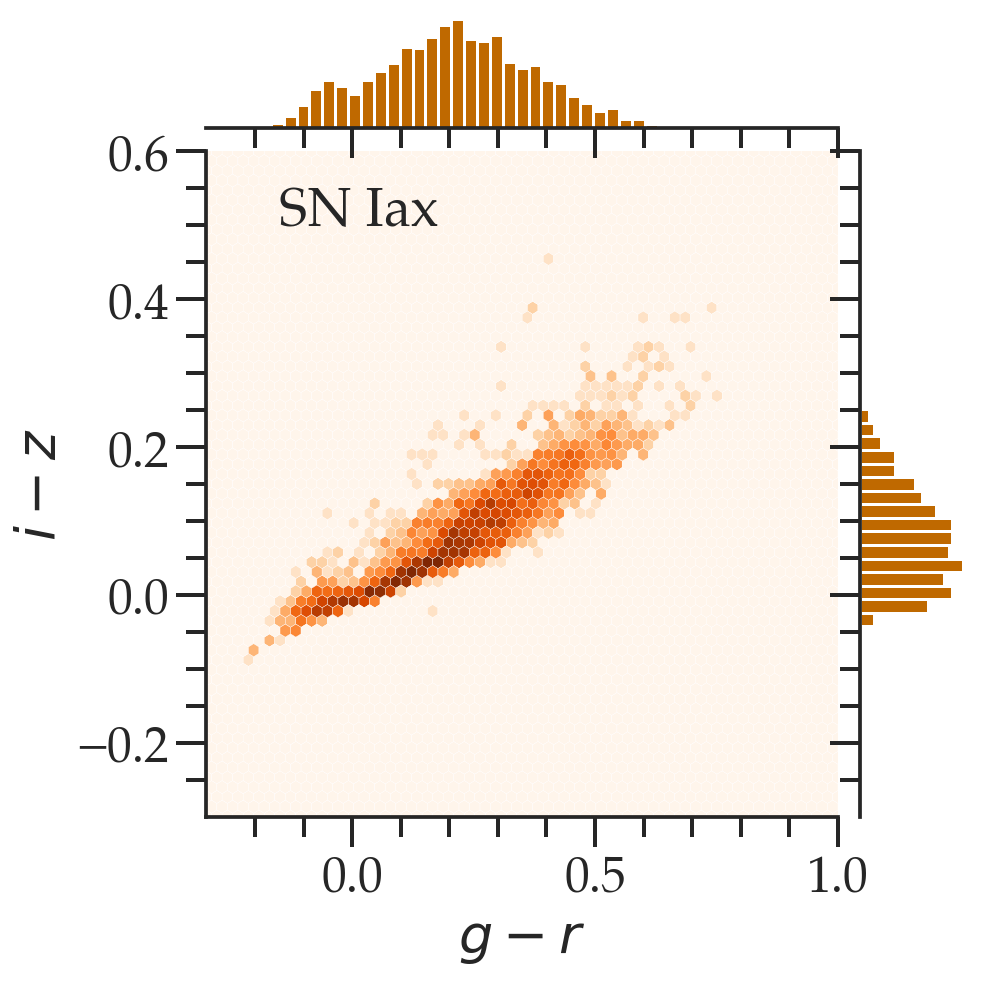

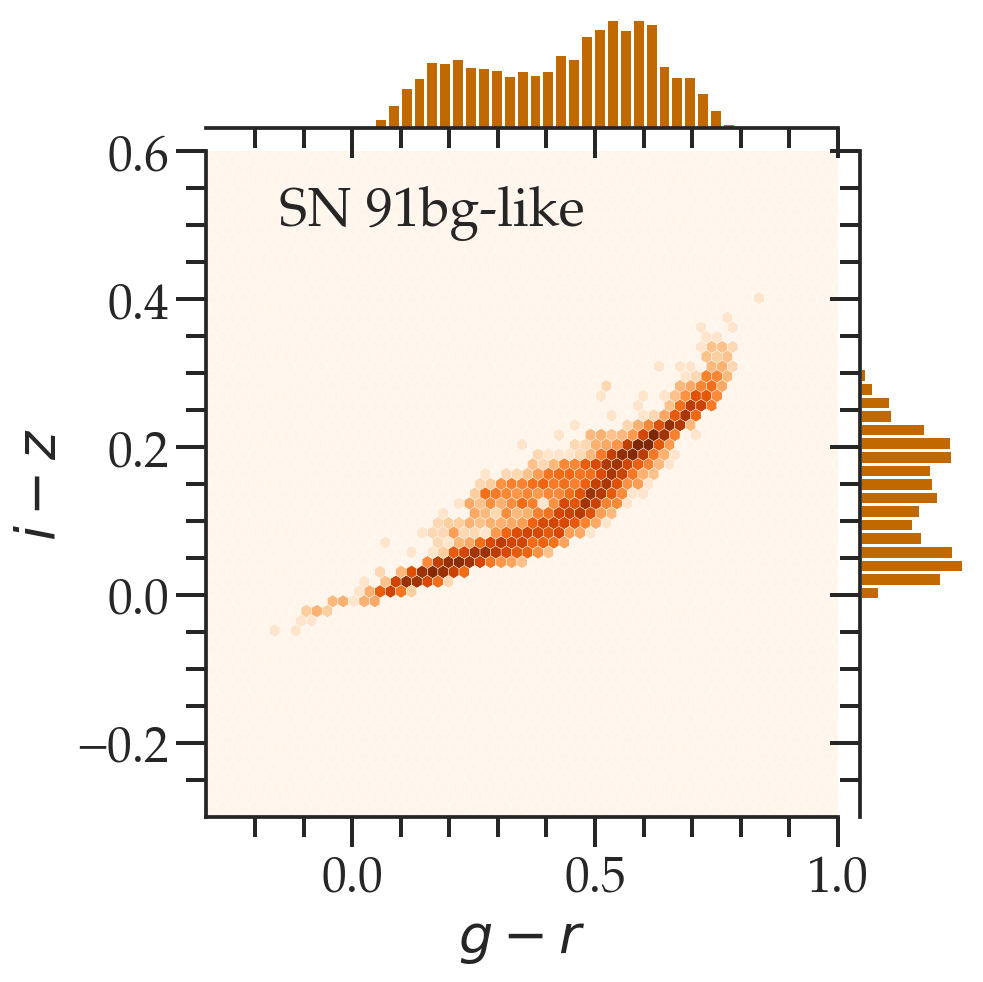

In [177]:
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

classes_plot = [classes[3], classes[6]]
names_plot = ['SN Iax', 'SN 91bg-like']


bands = ['g', 'r', 'i', 'z']

cols = sns.color_palette("colorblind", 12)
N4993_g = 15.0769
N4993_r = 14.153
N4993_i = 13.9573
N4993_z = 13.42
N4993_y = 13.2019

for i in np.arange(len(classes_plot)):
    g_min_r = classes_plot[i]["Mag_true_g_lsst_z0"].values - classes_plot[i]["Mag_true_r_lsst_z0"].values
    r_min_i = classes_plot[i]["Mag_true_r_lsst_z0"].values - classes_plot[i]["Mag_true_i_lsst_z0"].values
    i_min_z = classes_plot[i]["Mag_true_i_lsst_z0"].values - classes_plot[i]["Mag_true_z_lsst_z0"].values

    g = sns.JointGrid(x=g_min_r, y=i_min_z,  xlim=(-0.3, 1.), ylim=(-0.3, 0.6), height=7)
    g = g.plot_joint(plt.hexbin, color="#4CB391",cmap='Oranges', edgecolor="w",linewidth=0.2, gridsize=60, extent=[-0.3, 1., -0.3, 0.6], bins='log')
    _ = g.ax_marg_x.hist(g_min_r,
                          bins=np.linspace(-0.3, 1., 50), density=True, fill=True, color='#BF6900')
    _ = g.ax_marg_y.hist(i_min_z, 
                          orientation="horizontal",
                          bins=np.linspace(-0.3,0.6, 50), density=True, Fill=True, color='#BF6900')

    if names[i] == 'Kilonova':
        g.ax_joint.plot(N4993_g - N4993_r, N4993_i - N4993_z, 'd', c='#00A6A6', ms=15)
    plt.xlabel(r"$g-r$")
    plt.text(-0.15, 0.5, "%s"%names_plot[i])
    plt.ylabel(r"$i-z$")
    plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_HexGrid_%s_gr_iz.png"%names_plot[i].replace(" ", ""),bbox_inches='tight',dpi=200)

In [243]:
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots

bands = ['g', 'r', 'i', 'z']

cols = sns.color_palette("colorblind", 10)

g_min_r = GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'gKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'rKronMag'].values
r_min_i =  GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'rKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'iKronMag'].values
i_min_z =  GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'iKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'zKronMag'].values

g = sns.JointGrid(x=g_min_r, y=i_min_z,  xlim=(-0.1, 1.), ylim=(-0.1, 0.6), height=7)
g = g.plot_joint(plt.hexbin, color="#4CB391",cmap='Oranges', edgecolor="w",linewidth=0.2, gridsize=40, extent=[-0.1, 1., -0.1, 0.6], bins='log')
_ = g.ax_marg_x.hist(g_min_r,
                      bins=np.linspace(-0.1, 1, 50), density=True, fill=True, color='#BF6900')
_ = g.ax_marg_y.hist(i_min_z, 
                      orientation="horizontal",
                      bins=np.linspace(-0.1, 0.6, 50), density=True, Fill=True, color='#BF6900')
g.fig.suptitle("GHOST: SNe Ia", fontsize=30, y=1.05)
plt.xlabel(r"$g-r$")
plt.ylabel(r"$i-z$")

NameError: name 'GHOST' is not defined

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/alexgagliano/miniconda3/lib/pytho

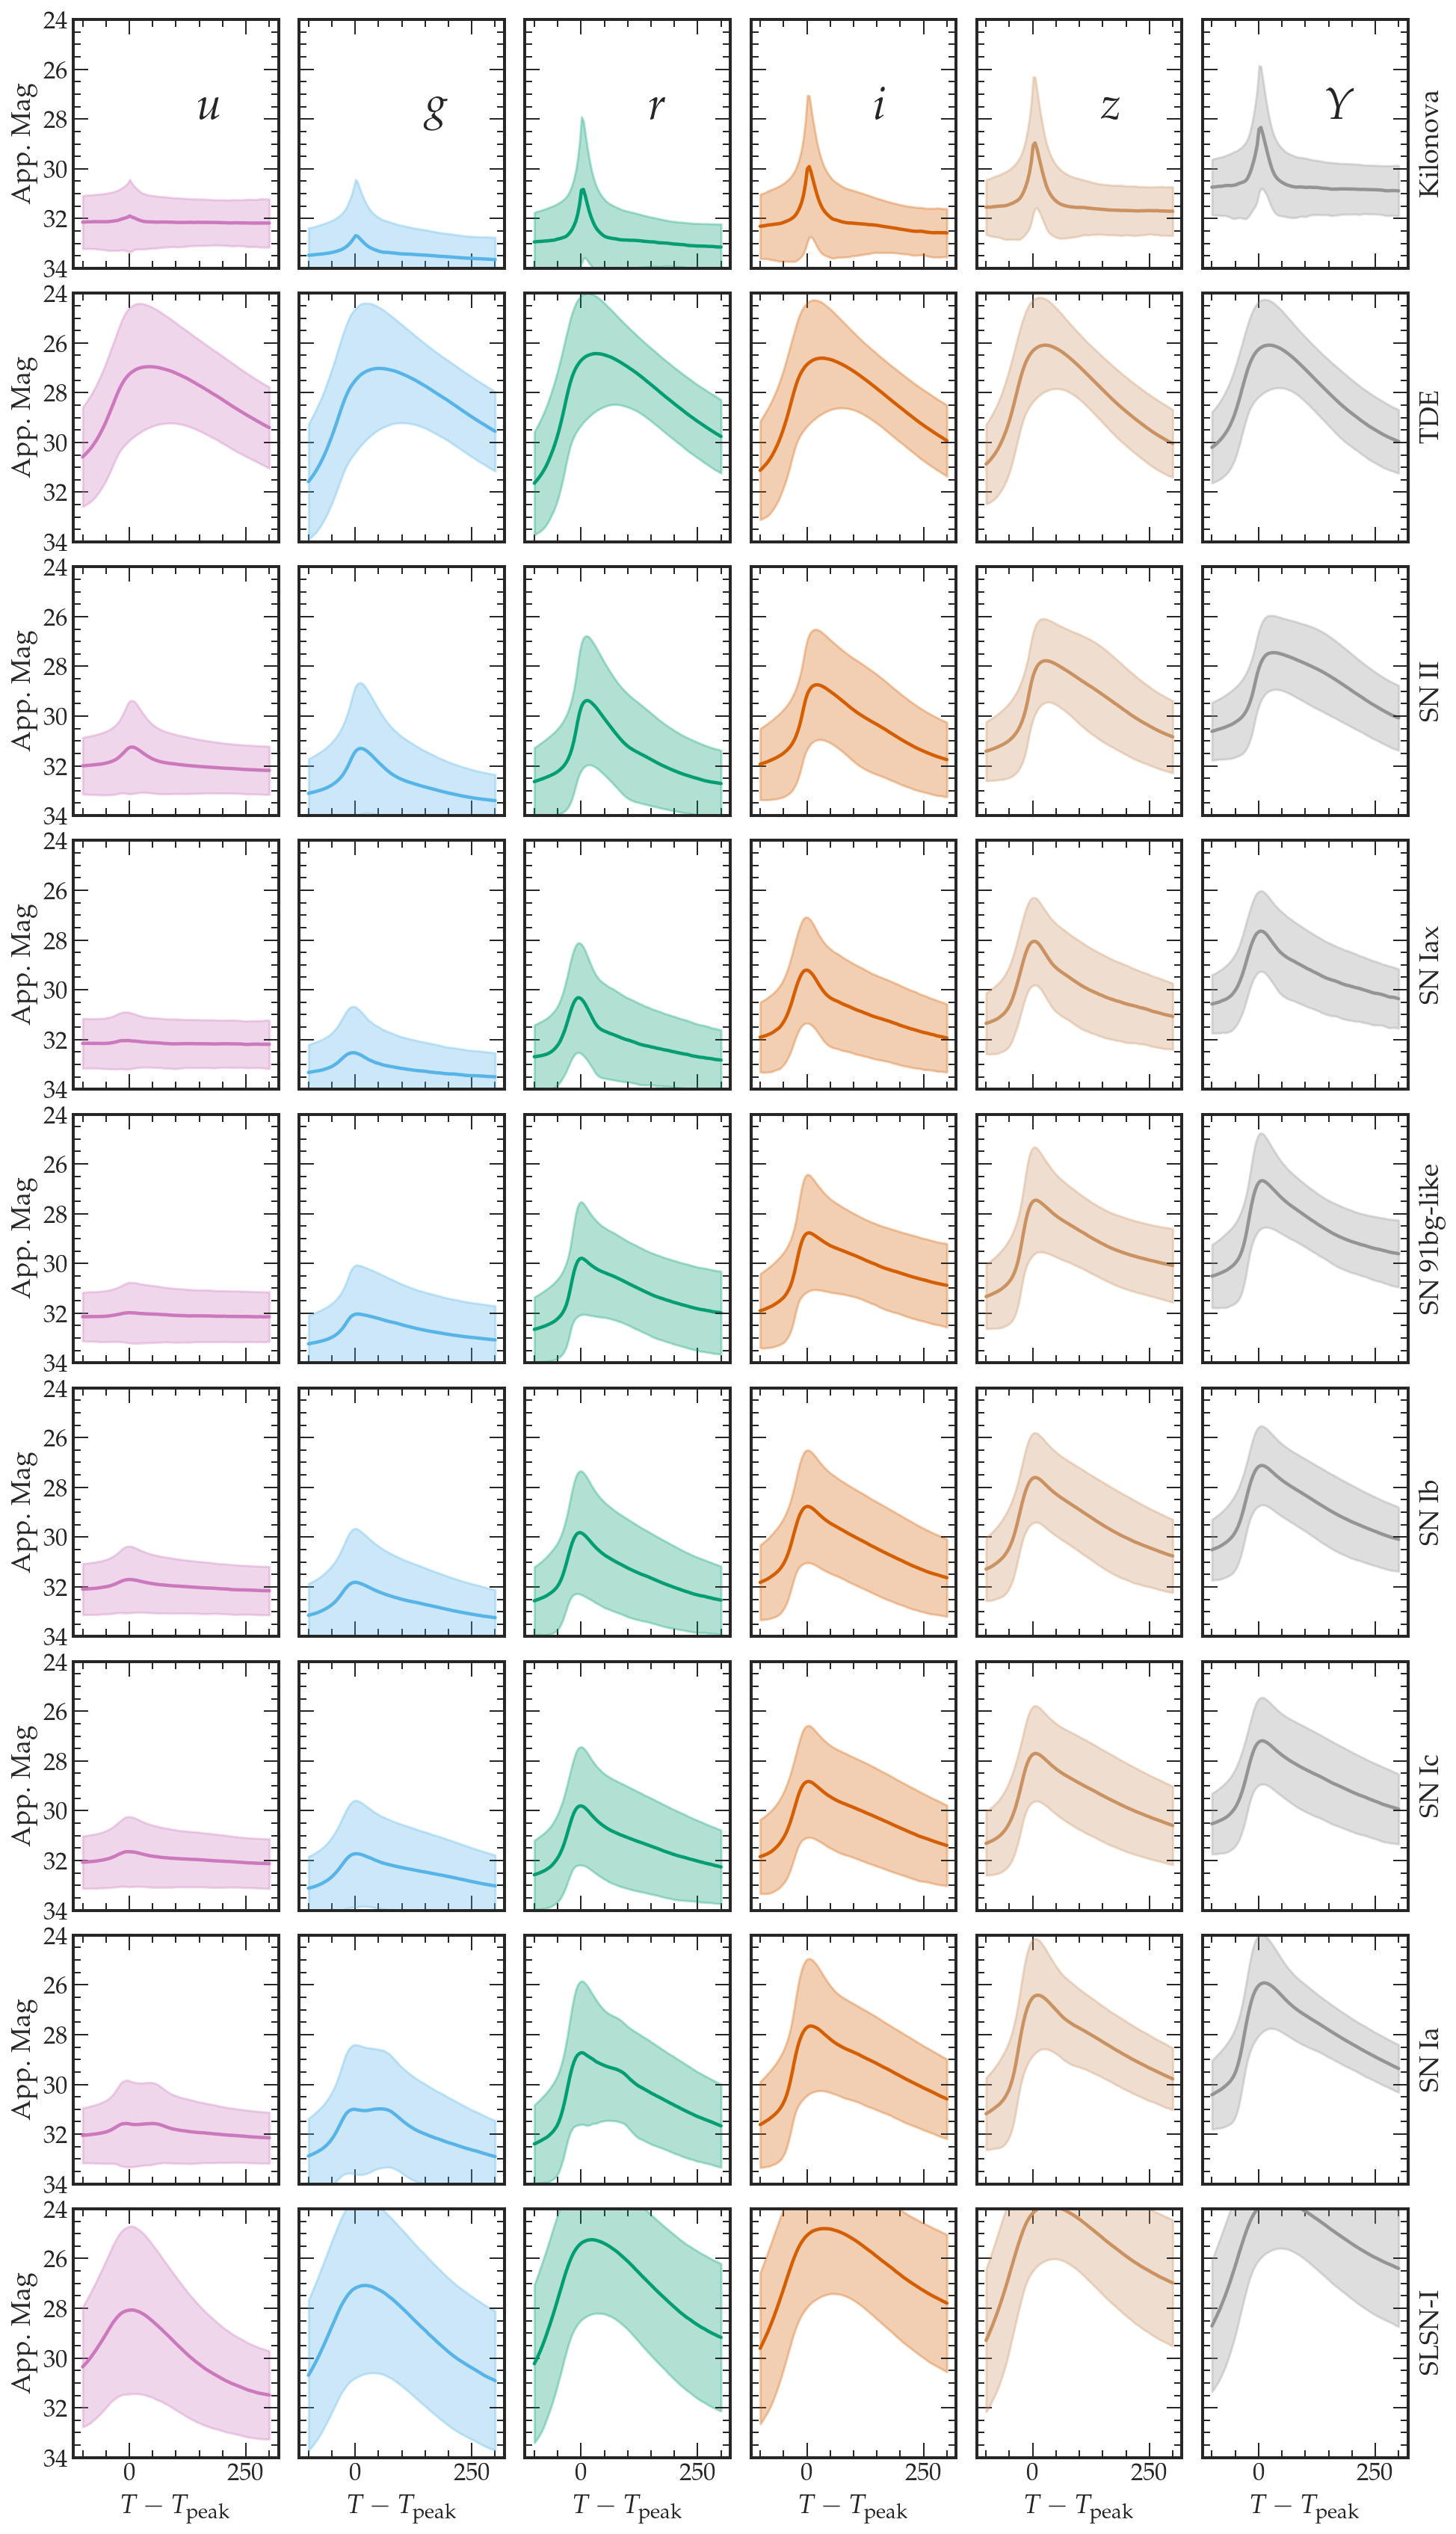

In [180]:
sns.set_context("talk",font_scale=1.)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

bands = ['u', 'g', 'r', 'i', 'z', 'Y']
classes_plot = [KN,TDE, CC, SNIax, SNIa91bg, SNIb, SNIc, SNIa, SLSN] 
names_plot = ['Kilonova', 'TDE','SN II', 'SN Iax',  'SN 91bg-like', 'SN Ib', 'SN Ic', 'SN Ia',  'SLSN-I']

#AGN, SNIcBL, SNIIn, SNIIb

cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], cols[7], cols[8]]) #u and y probably need changing

fig, axs = plt.subplots(figsize=(16,30), nrows=9, ncols=6,sharex=True, sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.1})
for j in np.arange(len(classes_plot)):
    for k in np.arange(len(bands)):
        # plt.figure(figsize=(10,7))
        tnew = np.linspace(-100, 300, 100)
        
        mag_set = []
        for idx, row in classes_plot[j].iterrows():
            if len(row['mjd_%s'%bands[k]]) > 0:
                time = row['mjd_%s'%bands[k]]-row['pkmjd']
                mag = row['mag_%s'%bands[k]]
                SNR = row['snr_%s'%bands[k]]
                time = time[mag < 37]
                mag = mag[mag < 37]
                if len(time)>1:
                   # plt.plot(time, mag, c='grey', alpha=0.05)
                    f = interpolate.interp1d(time, mag, bounds_error=False)
                    mag_new = f(tnew)
                    mag_set.append(mag_new)

        event_mmag = []
        event_stdmag = []
        for i in np.arange(len(tnew)):
            event_mmag.append(np.nanmean([x[i] for x in mag_set]))
            event_stdmag.append(np.nanstd([x[i] for x in mag_set]))

        event_mmag = np.array(event_mmag)
        event_stdmag = np.array(event_stdmag)

        axs[j,k].fill_between(tnew, event_mmag-event_stdmag, event_mmag+event_stdmag, alpha=0.3, color=cols[k])
        axs[j,k].plot(tnew, event_mmag, c=cols[k])
        axs[j,k].set_ylim((24, 34))
        if k==0:
            axs[j,k].set_ylabel("App. Mag")
        axs[j,k].invert_yaxis()
        
        ax2 = axs[j,k].twinx()
        ax2.set_yticklabels([''])
        if k==5:
            ax2.set_ylabel(names_plot[j], rotation=90)
        if j==8:
            axs[j,k].set_xlabel(r"$T-T_{\rm peak}$")
        if j==0:
            axs[j,k].text(145, 28, r"$%s$"%bands[k], fontsize=30)
plt.savefig("../plots/Model_LCs_ugrizY.png",bbox_inches='tight',dpi=200)

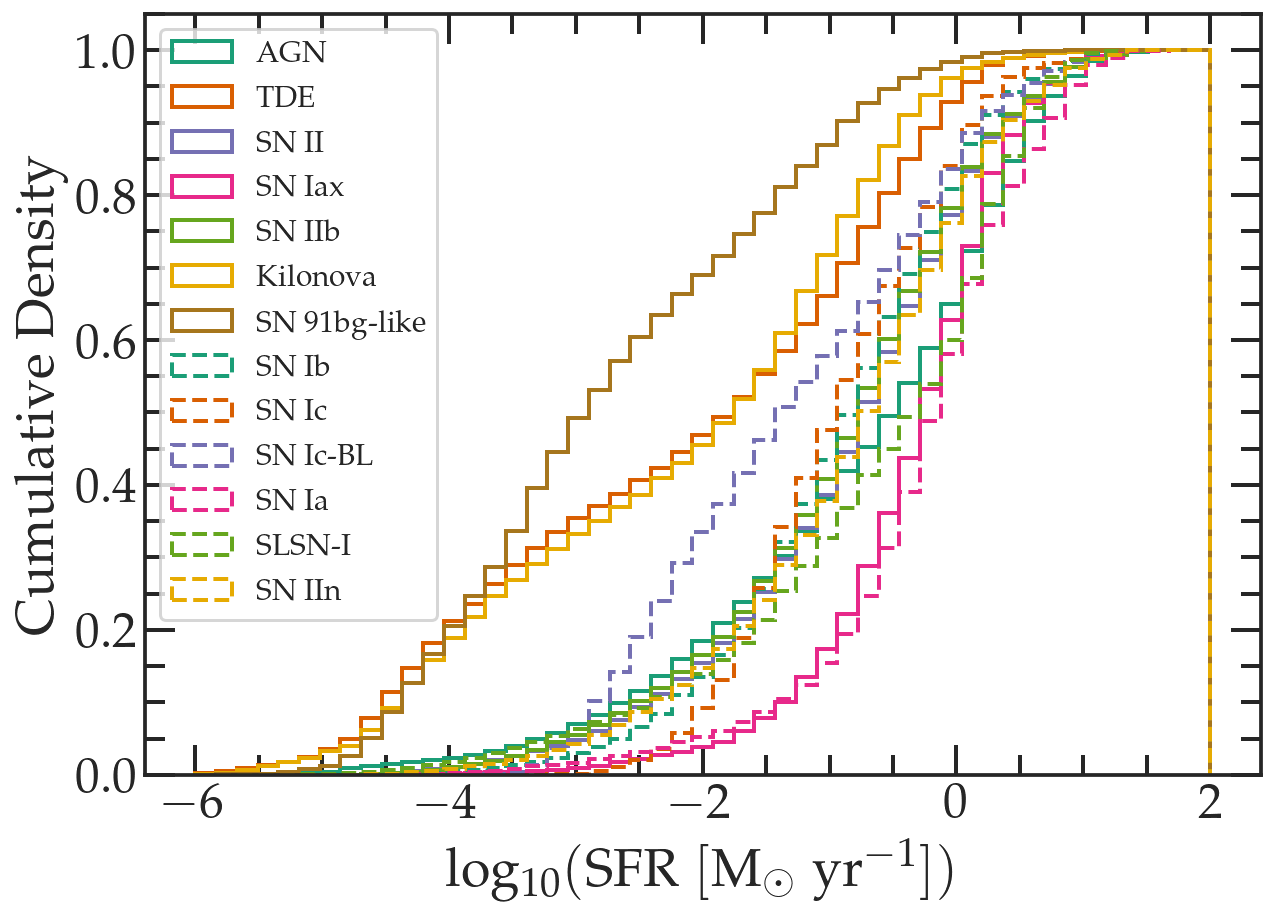

In [42]:
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)


plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
    plt.hist(tclass['SIM_HOSTLIB(LOG_SFR)'], density=True, histtype='step', cumulative=True, bins=np.linspace(-6, 2, 50), ls=ls, color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{SFR}\; [M_{\odot}\; yr^{-1}])$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/ELAsTiCC_CDF_SFR.png",bbox_inches='tight', dpi=200)

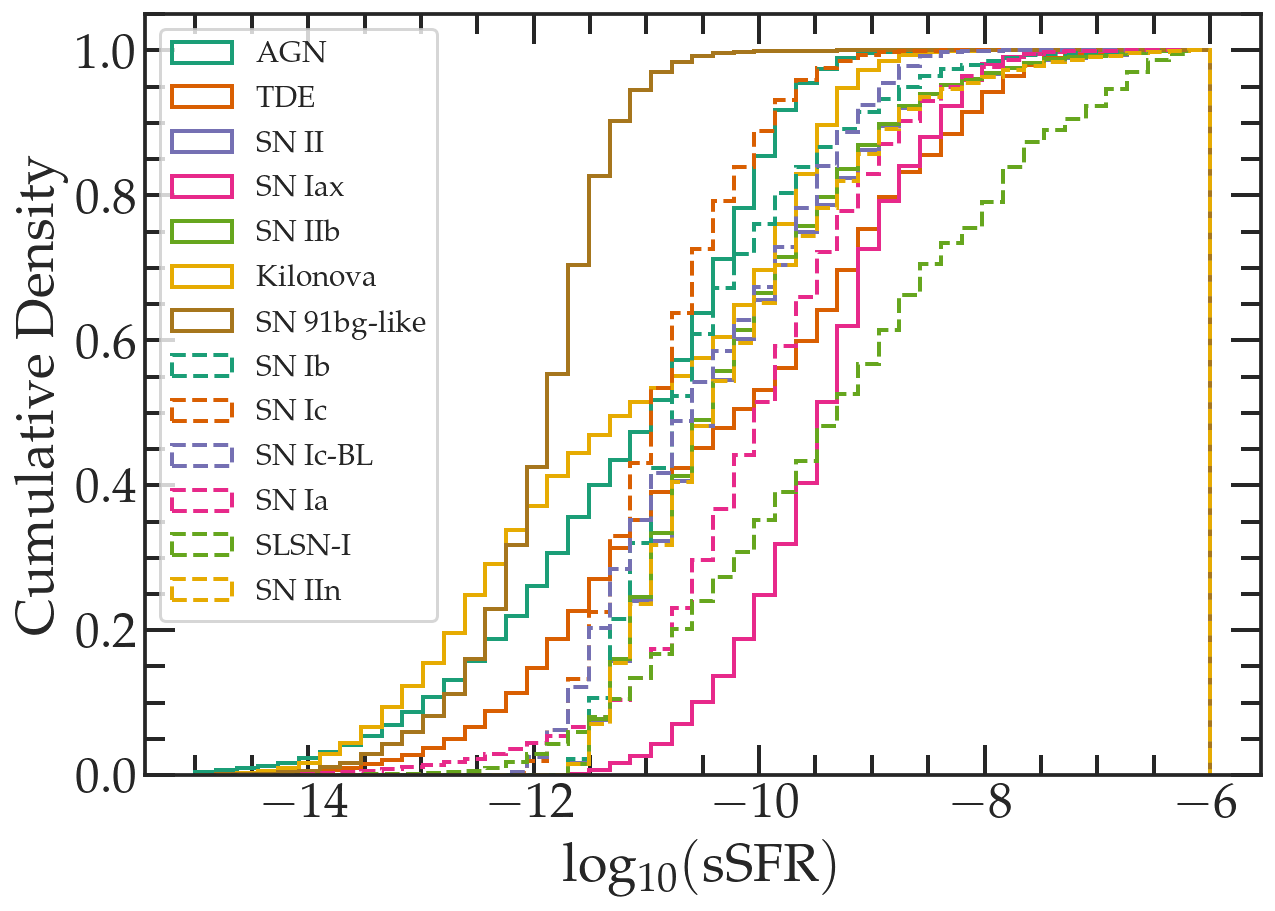

In [48]:
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)


plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
        
    sSFR = np.log10(10**tclass['SIM_HOSTLIB(LOG_SFR)']/10**tclass['SIM_HOSTLIB(LOGMASS_TRUE)'])
    plt.hist(sSFR, density=True, histtype='step', cumulative=True, bins=np.linspace(-15, -6, 50), ls=ls, color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{sSFR})$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/ELAsTiCC_CDF_sSFR.png",bbox_inches='tight', dpi=200)

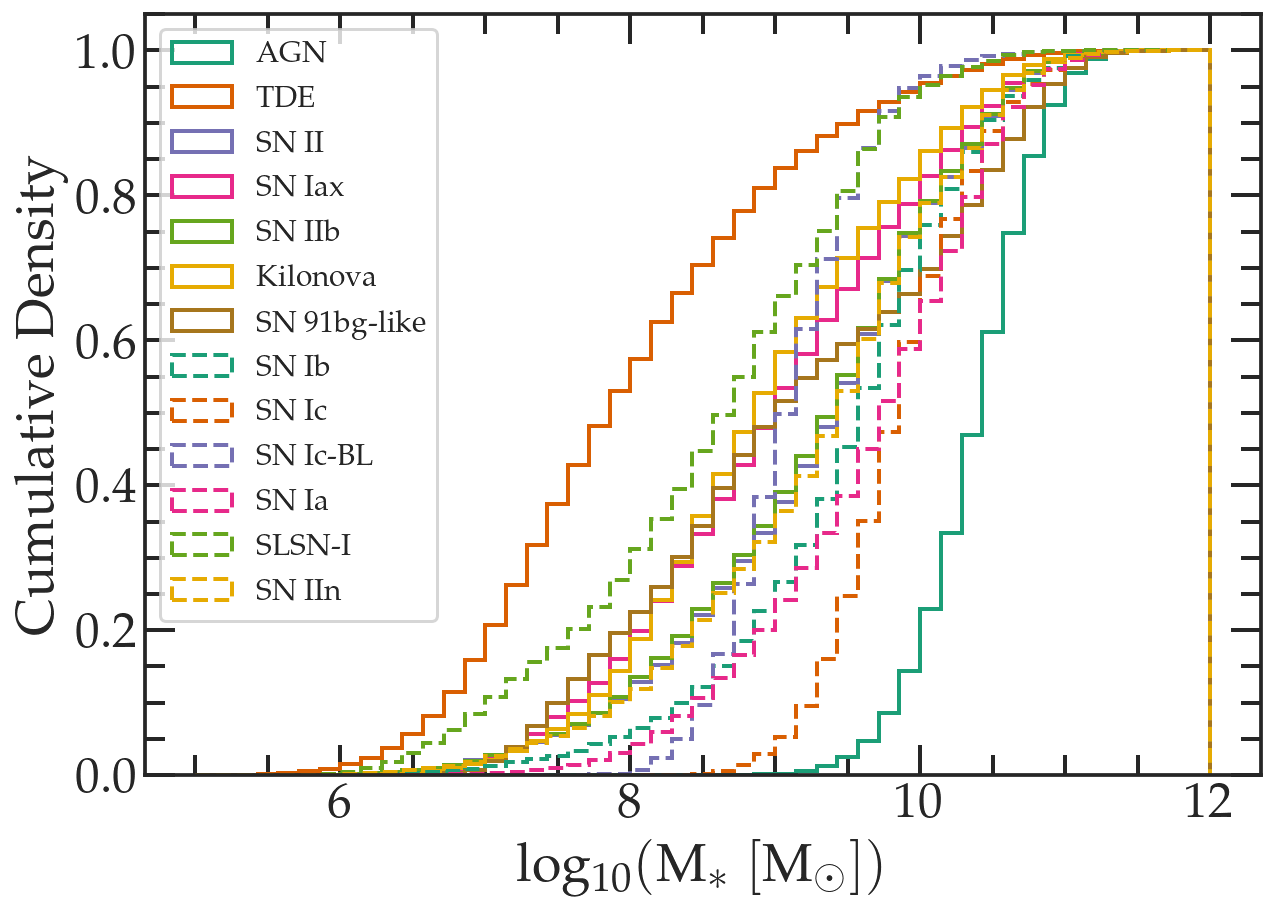

In [38]:
lines = ["-","--","-.",":"]
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)

plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
    plt.hist(tclass['SIM_HOSTLIB(LOGMASS_TRUE)'], density=True, histtype='step', cumulative=True,ls=ls, bins=np.linspace(5, 12, 50), color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{M_{*}}\; [M_{\odot}])$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/ELAsTiCC_CDF_Msol.png",bbox_inches='tight', dpi=200)